In [1]:
# Python SQL toolkit and Object Relational Mapper
import pandas as pd
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy import Column, Integer, String, Float, Text, ForeignKey

In [2]:
# Create engine using the `hawaii.sqlite` database file

engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
# Declare a Base using `automap_base()`

Base = automap_base()

In [4]:
# Use the Base class to reflect the database tables

Base.prepare(engine, reflect=True)

In [5]:
# Print all of the classes mapped to the Base
Base.classes.keys()

# Did not intend to create all of these classes but don't know how to correct

['Stations',
 'hawaii_measurements',
 'hawaii_stations',
 'measurement',
 'measurements',
 'station']

In [6]:
# Assign the class to a variable 

Measurements = Base.classes.hawaii_measurements
Stations = Base.classes.hawaii_stations

In [7]:
# Create a session

session = Session(engine)

In [8]:
# Use the session to query Measurements table and display the first 5 rows
for row in session.query(Measurements).limit(5).all():
    print(row)

In [9]:
#Select first row from mesurements table
session.query(Measurements.station,Measurements.date,Measurements.prcp, Measurements.tobs).first()

('USC00519397', '2010-01-01', 0.08, 65.0)

In [10]:
#Select first row from stations
session.query(Stations.station,Stations.name,Stations.latitude, Stations.longitude,Stations.elevation).first()


('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)

   ### Precipitation Analysis
   

In [11]:
#Query 12 months of precipiation data. 8/23/16-8/23/17


precipitation_year = session.query(Measurements.date,func.avg(Measurements.prcp)) \
             .filter(Measurements.date >= '2016-08-23').filter(Measurements.date <= '2017-08-23') \
             .group_by(Measurements.date).all()

In [12]:
# Load the results into a pandas dataframe. 
# Filter to only the date and prcp values.
precipitation_measurement_df = pd.DataFrame(precipitation_year[:], columns=['Date','prcp',])

precipitation_measurement_df['Date'] =  pd.to_datetime(precipitation_measurement_df['Date'])
precipitation_measurement_df.set_index('Date', inplace=True)
precipitation_measurement_df.head()

,prcp
Date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


<IPython.core.display.Javascript object>


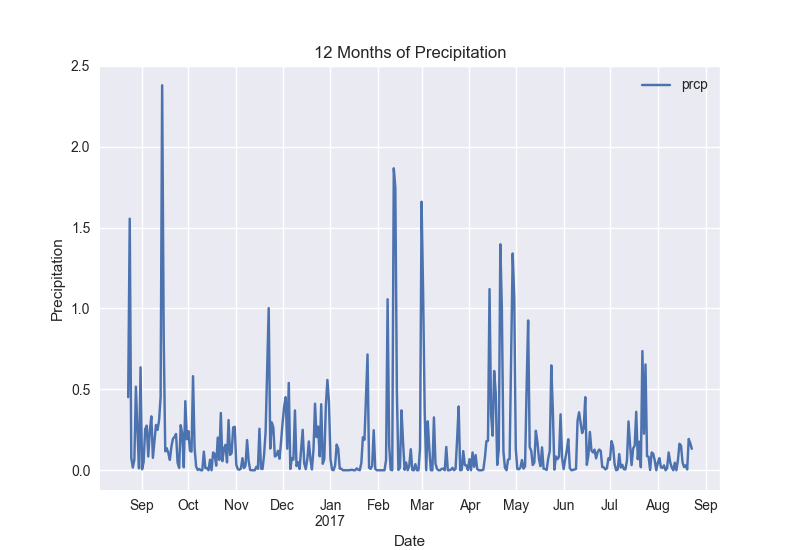

In [13]:
# Plot last twelve months of precipitation
precipitation_measurement_df.plot()
plt.title("12 Months of Precipitation")
plt.ylabel("Precipitation")
plt.show()

In [14]:
# Use Pandas to print the summary statistics for the precipitation data.
precipitation_measurement_df.describe()

,prcp
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


### Station Analysis

In [15]:
# Calculate the total number of stations
session.query(Stations.station).count()

9

In [16]:
# Find the most active stations
# List stations and observation counts in descending order

active_station = session.query(Measurements.station,func.count(Measurements.date)) \
             .group_by(Measurements.station)

In [17]:
active_station_df = pd.DataFrame(active_station[:], columns=['station','tobs',])
active_station_df.sort_values("tobs", ascending=[False], inplace=True)
active_station_df.set_index('station', inplace=True)
active_station_df.head()

,tobs
station,
USC00519281,2772
USC00513117,2696
USC00519397,2685
USC00519523,2572
USC00516128,2484


In [18]:
# Retrieve the last 12 months of temperature observation data (tobs)
# Filter by the station with the highest number of observations.

temperature_year = session.query(Measurements.date,Measurements.tobs) \
             .filter(Measurements.date >= '2016-08-23').filter(Measurements.date <= '2017-08-23') \
             .filter(Measurements.station == 'USC00519281').all()

temperature_measurement_df = pd.DataFrame(temperature_year[:], columns=['Date','tobs',])
temperature_measurement_df.head()

,Date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


<IPython.core.display.Javascript object>


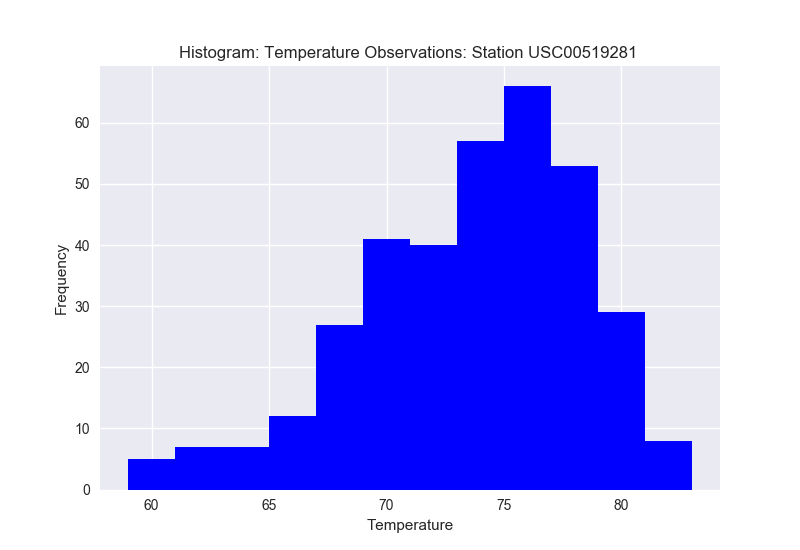

In [19]:
#Plot the results as a histogram with bins=12.
temperature_measurement_df["tobs"].hist(bins=12, color="blue")
plt.title("Histogram: Temperature Observations: Station USC00519281 ")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.savefig("Histogram: Temperature Observations: Station USC00519281")
plt.show()

### Temperature Analysis

In [20]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    results = session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()
    
    return pd.DataFrame(results, columns= ["Avg_temp","Min_temp","Max_temp"])
print(calc_temps('2016-08-23', '2016-09-05'))

   Avg_temp   Min_temp  Max_temp
0      71.0  78.181818      84.0


In [21]:
# Plot the min, avg, and max temperature from your previous query as a bar chart.
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).
week_analysis_df = calc_temps('2016-08-23', '2016-09-05')

week_analysis_df.head()

,Avg_temp,Min_temp,Max_temp
0,71.0,78.181818,84.0


<IPython.core.display.Javascript object>


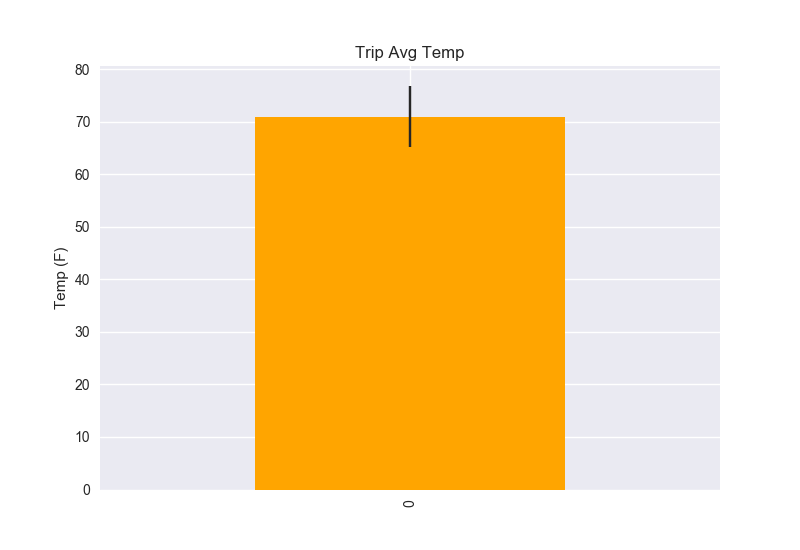

In [22]:
means = week_analysis_df["Avg_temp"]
errors = week_analysis_df["Min_temp"]-week_analysis_df["Max_temp"]

fig, ax = plt.subplots()

means.plot.bar(yerr=errors, ax=ax, color="orange")
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")

plt.show()